In [103]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from os.path import join as pjoin
from scipy.stats.mstats import winsorize
from matplotlib import pyplot as plt


In [5]:
tmp_data_path = './data/tmp'


s_year = 1997
e_year = 2020

load data

In [43]:
df_ma = pd.read_pickle(pjoin(tmp_data_path , f'merged_model_{s_year}_{e_year}.pickle'))

In [58]:
df_fv_raw = pd.read_pickle(f'{tmp_data_path}/fv_raw_{s_year}_{e_year}.pickle')

recall that we have 2 types of public condition; 2 types of merge events

- 3,9: target = `AUP` acquirer `TUP` 
- 1,7: target = `AUP` acquirer `TPU`



|         | PubCond = 1,7 | PubCond = 3,9 |       |
|---------|---------------|------------------|-------|
| STATC=C | 5902          | 7991             | 13893 |
| STATC=W | 844           | 195              | 1039  |
|         | 6746          | 8186             |       |



SUMMARY:
- Our Goal is to modeling 2 types of MA events,
    - for each of which, anwsering: why some fail and why some success

In [85]:
df_fv_raw.head(10)

,gvkey,year,at,sale,m2b,lev,roa,ppe,cash2asset,cash2sale,sale2asset,cr,d_sale,d_at
0,1004,1997,529.584,589.328,1.495681,0.223368,0.043478,0.134271,0.097633,0.087736,1.112813,4.141787,NaN,NaN
1,1004,1998,670.559,782.123,1.588650,0.265071,0.053175,0.123636,0.025683,0.022020,1.166375,3.140505,0.327144,0.266200
2,1004,1999,726.630,918.036,1.233778,0.249589,0.057348,0.143143,0.011354,0.008987,1.263416,2.927575,0.173774,0.083618
3,1004,2000,740.998,1024.333,0.969253,0.279030,0.047454,0.148452,0.001675,0.001212,1.382369,3.120983,0.115787,0.019773
4,1004,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1004,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1004,2003,686.621,606.337,0.746207,0.374171,-0.018074,0.242872,0.042460,0.048082,0.883074,1.947253,NaN,NaN
7,1004,2004,709.292,651.958,0.985331,0.355366,0.004940,0.234229,0.057818,0.062903,0.919167,3.292707,0.075240,0.033018
8,1004,2005,732.230,747.848,1.259272,0.315344,0.025364,0.190018,0.055321,0.054166,1.021329,2.965424,0.147080,0.032339
9,1004,2006,978.819,897.284,1.443958,0.327808,0.035924,0.217997,0.124372,0.135674,0.916701,3.325314,0.199821,0.336764


In [88]:
# define a helper function

def plot_missing(df):
    df = df.sort_values([ 'year', 'gvkey'], ascending=True)
    
    plt.figure(figsize=(12,5))
    plt.plot(list(df.isnull().sum(axis=1)), label = "num of missing") 
    plt.grid()
    plt.title('row missing')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12,5))
    axes = plt.gca()
    axes.set_ylim([0, df.shape[0]])
    plt.plot(list(df.isnull().sum(axis=0)),  label = "num of missing")
    xint = range(0, df.shape[1])
    plt.xticks(xint)
    plt.title('colomn missing')
    plt.grid()
    plt.legend()
    plt.show()
    
    print("variable missing percentage : \n", (df.isnull().sum(axis=0) / df.shape[0])*100)
    print("variable names: ", df.columns)

# The general missing pattern of financial vars

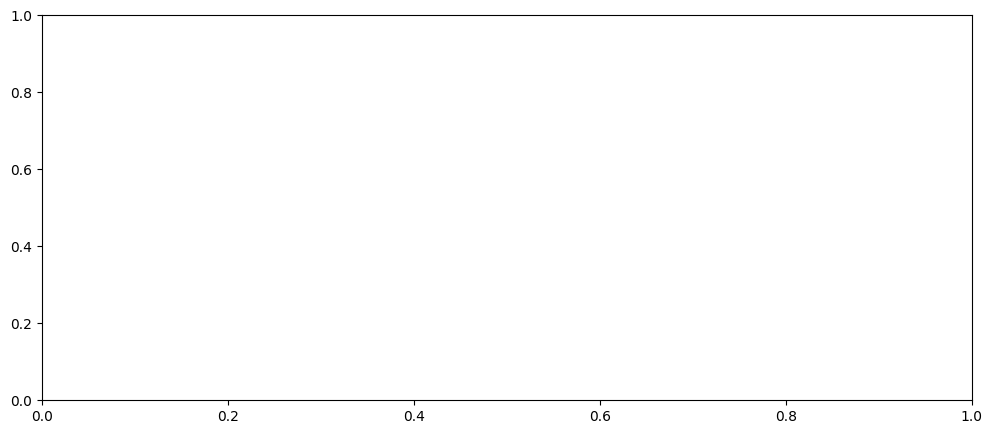

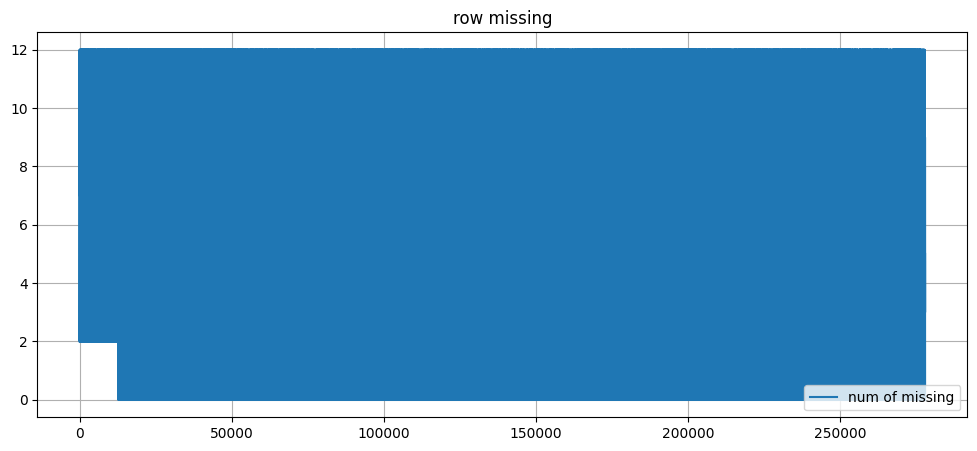

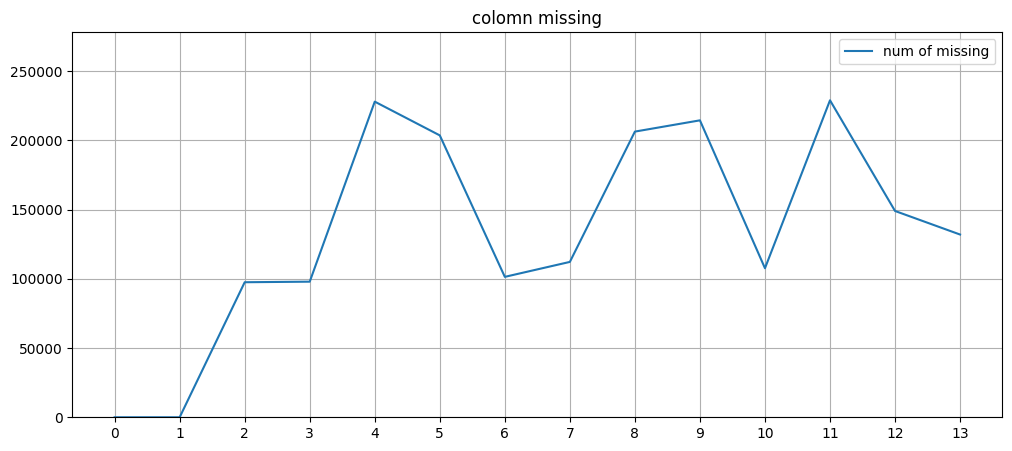

variable missing percentage : 
 gvkey          0.000000
year           0.000000
at            35.076560
sale          35.221909
m2b           81.984659
lev           73.218397
roa           36.472125
ppe           40.354809
cash2asset    74.202020
cash2sale     77.126266
sale2asset    38.712080
cr            82.329683
d_sale        53.583712
d_at          47.463951
dtype: float64
variable names:  Index(['gvkey', 'year', 'at', 'sale', 'm2b', 'lev', 'roa', 'ppe', 'cash2asset',
       'cash2sale', 'sale2asset', 'cr', 'd_sale', 'd_at'],
      dtype='object')


In [89]:
plot_missing(df_fv_raw)

# Dealing with NAs

First, one 1 condition we could analysis is that:
- both acquirer and the target has financial variable match
    - and their financial var has no missing values


    
Since we will never use some `gvkey-year` pair (hopefully they are the ones which have a lot of NAs), we first mark if the gvkey in `df_fv_raw` will be used further
- will use: 1
- will not: 0
    


In [72]:
df_ma.shape

(14932, 39)

In [65]:

merge_a = df_ma.merge(df_fv_raw, how = 'inner', left_on=['AGVKEY', 'YEAR'], right_on = ['gvkey','year'])
merge_t =  merge_a.merge(df_fv_raw, how = 'inner', left_on=['TGVKEY', 'YEAR'], right_on = ['gvkey','year'])



In [67]:
merge_t.shape

(10187, 67)

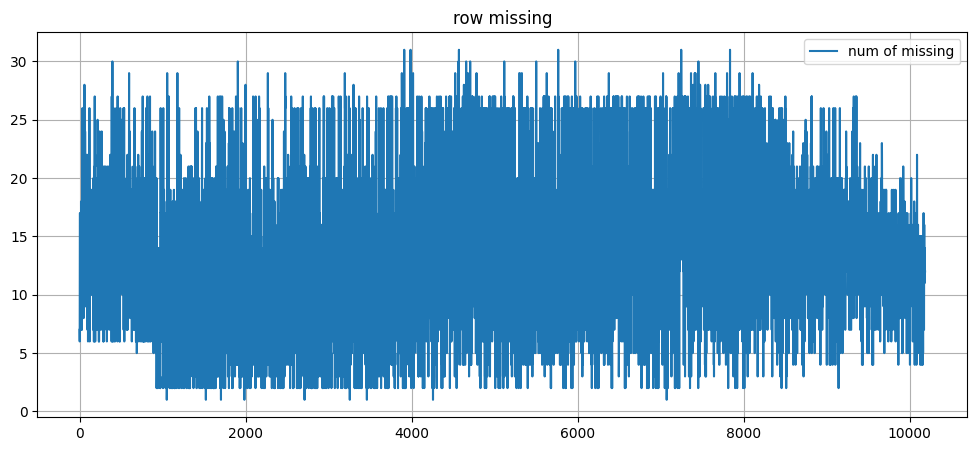

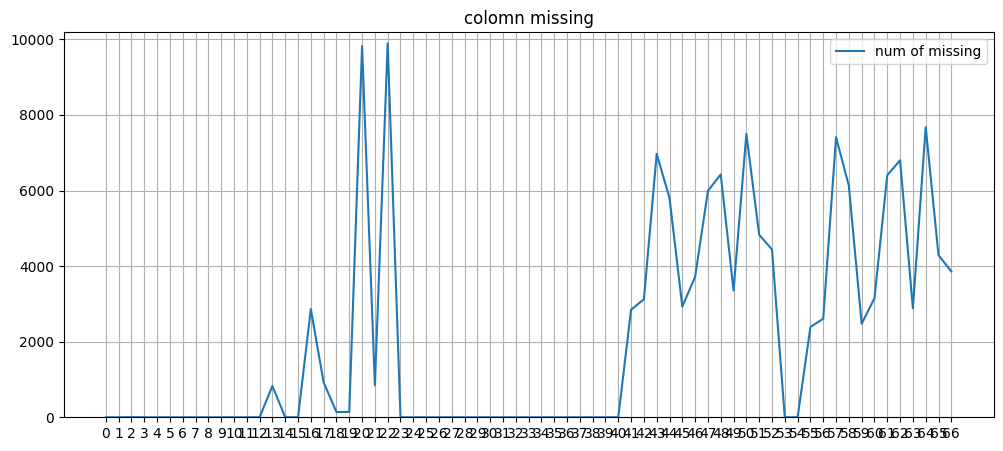

missing percentage : 
 ACU              0.000000
ASIC2            0.000000
ABL              0.049082
ANL              0.000000
APUBC            0.000000
                  ...    
cash2sale_y     66.741926
sale2asset_y    28.320408
cr_y            75.341121
d_sale_y        42.102680
d_at_y          37.891430
Length: 67, dtype: float64


In [70]:
plot_missing(merge_t)

- after merge with financial variable, we loss about 1/3 of the MA events

- The result shows that we have a lot of NAs for financial data.


## Threshold 


by doing experiment, 7 is a reasonable number for threshold.

Which means the max tolerance of num of missing values per row is 7...

In [101]:
# def helper fun
def deal_na(df, na_thres):
    '''
    df: raw financial varibale table
        - the first 2 columns are `gvkey` and `year`
        - the rest are fianncial variables
    
    '''
    n_features = len(df.columns) - 2
    ratio_pd_w = df
    # replace inf to na
    ratio_pd_w.replace([np.inf, -np.inf], np.nan, inplace=True)
    # count na of each row
    ratio_pd_w['n_na'] = ratio_pd_w.isna().sum(axis=1) # each row has how many Nas
     # only retain those Na < thres
    ratio_pd_w = ratio_pd_w[ratio_pd_w['n_na'] <= na_thres].reset_index(drop=True)
    
    for colname in ratio_pd_w.columns[2:(2+n_features)]:
        # remove outliers
        ratio_pd_w[colname] = winsorize(ratio_pd_w[colname], limits=[0.01, 0.01], nan_policy='omit')
        # impute na with mean
        ratio_pd_w[colname].fillna(value=ratio_pd_w[colname].mean(skipna=True), inplace=True)
    assert ratio_pd_w.isna().sum().sum() == 0
    return ratio_pd_w


def merge_fv_ma(df_fv_nona, df_ma):
    '''
    df_fv_nona: df_fv with no single missing value
    df_ma: 
    
    '''
    assert df_fv_nona.isna().sum().sum() == 0
    merge_a = df_ma.merge(df_fv_nona, how = 'inner', left_on=['AGVKEY', 'YEAR'], right_on = ['gvkey','year'])
    merge_t =  merge_a.merge(df_fv_nona, how = 'inner', left_on=['TGVKEY', 'YEAR'], right_on = ['gvkey','year'])

    #print("num of obs for original MA table: ", df_ma.shape[0], '\n')
    #print('num of obs in merged table:', merge_t.shape[0], '\n')
    
    return merge_t


In [107]:
# experiment:
remaining = []
for thres in range(0, df_fv_raw.shape[1]-2):
    #print(f" ########## when threshold is {thres}: ####### \n ")
    df_fv_nona = deal_na(df_fv_raw, thres)
    merged_fv_ma = merge_fv_ma(df_fv_nona, df_ma)
    remaining.append(merged_fv_ma.shape[0])
    

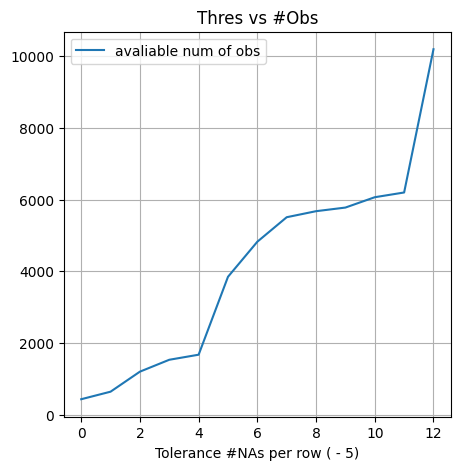

In [108]:



plt.plot(remaining, label = "avaliable num of obs") 
#plt.xlim([5, df_fv_raw.shape[1]-2])
plt.xlabel("Tolerance #NAs per row ( - 5)")
plt.grid()
plt.title('Thres vs #Obs')
plt.legend()
plt.show()  
